<a href="https://colab.research.google.com/github/yeonji200522-oss/Hands-on-Machine-Learning/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **3장 분류**
###**3.1 MNIST**
(MNIST: 미국 인구 조사과정에서 손으로 쓴 70,000개의 작은 숫자 이미지 데이터셋)  
사이킷런의 함수를 사용해 데이터셋 내려받기  


In [1]:
#OpenML.org에서 MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

sklearn.datasets에 있는 함수는 대부분 세 종류  
1. fetch_* 함수  
: fetch_openml()과 같이 실전 데이터셋을 다운로드하기 위한 함수  
2. load_* 함수  
: 사이킷런에 번들로 포함된 소규모 데이터셋을 로드하기 위한 함수  
3. make_* 함수  
: 테스트에 유용한 가짜 데이터셋을 생성하기 위한 함수  
생성된 데이터 셋은 일반적으로 넘파이 배열이며 입력과 타깃 데이터를 담은 (X, y) 튜플로 반환  
DESCR(데이터셋 설명), data(입력 데이터, 2D 배열), target(레이블, 1D 배열)의 속성으로 반환  
  
fetch_openml() 함수는 기본적으로 입력을 판다스 데이터프레임, 레이블을 판다스 시르즈로 반환  
하지만 MNIST 데이터셋은 이미지이므로 데이터프레임이 잘 맞지 않기에 as_frame=False로 지정해 넘파이 배열로 데이터 받기.

In [2]:
#as_frame=False로 지정해 넘파이 배열
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
X.shape

(70000, 784)

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
y.shape

(70000,)

위의 내용을 살펴보면 70,000개의 이미지, 각 이미지에는 784개의 특성 존재. (이미지는 28x28)  
각각의 특성은 0 (흰색)~ 255 (검은색)까지의 픽셀 강도  
샘플의 특성 벡터를 추출해 28x28 배열로 크기를 바꾸고 맷플롯립의 imshow() 함수를 사용해 그림  
아래는 cmap="binary"로 지정해 흑백 컬러 맵 사용

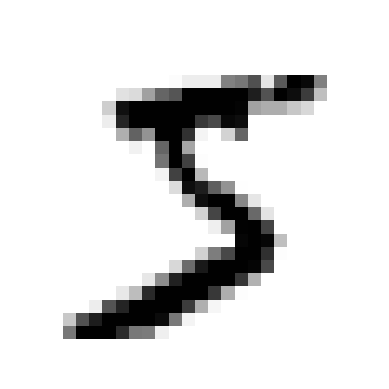

In [6]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
  image=image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
# 실제 레이블 확인
y[0]

'5'

데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 뗴어놓아야 함  
fetch_openml()이 반환한 MNIST 데이터셋은 이미 훈련세트와 테스트 세트로 나뉘어있음

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있기에 모든 교차 검증 폴드를 비슷하게 만든다. 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐. 그렇기에 데이터셋을 섞어 이런 문제 방지

###**3.2 이진 분류기 훈련**
두 개의 클래스를 구분할 수 있는 이진 분류기

In [9]:
# 분류 작업을 위한 타깃 벡터 생성
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법 (SDG) 분류기로 시작  
+ 이 분류기의 장점은 매우 큰 데이터셋을 효율적으로 처리할 수 있음,   


In [10]:
# SDGClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

###**3.3 성능 측정**
####**3.3.1 교차 검증을 사용한 정확도 측정**
cross_val_score()함수로 폴드가 3개인 k-폴드 교차 검증을 사용해 SGDClassifier모델 평가  
: k-폴드 교차 검증은 훈련 세트를 k개의 폴드로 나누고 평가를 위해 매번 다른 폴드를 떼어 모델을 k번 훈련

In [12]:
# 교차 검증 규현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))


0.95035
0.96035
0.9604


In [13]:
# 정확도 확인
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

위를 확인하면 모든 교차 검증 폴드에 대해 정확도가 95% 이상임을 확인

In [14]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [15]:
# 모델의 정확도 추측
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

위와 같은 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌  
불균형한 데이터셋을 다룰 때 더욱 문제가 있기에 분류기의 성능을 평가하는 방법으로 오차 행렬 추천  


####**3.3.2 오차 행렬**
오차 행렬의 기본 아이디어는 모든 A/B 쌍에 대해 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것  
오차 행렬을 만들기 위해서는 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함. cross_val_predict()함수를 사용

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 함수처럼 cross_val_predict() 함수는 k-폴드 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환.  
=> 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻음  
  
confusion_matrix() 함수를 사용해 오차 행렬을 만들기 위해 타깃 클래스와 예측 클래스를 넣어 호출

In [17]:
#confusion_matrix() 함수를 사용해 오차 행렬 생성
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내며 열은 예측한 클래스를 나타냄  
+ 1종 오류
: 행렬의 첫 번째 행은 '5 아님' 이미지(음성 클래스)에 대한 것으로 53,892개 를 5가 아님으로 정확하게 분류(진짜 음성), 나머지 687개는 5라고 잘못 분류 (거짓 양성/1종 오류)
+ 2종 오류
: 두 번째 행은 5에 대한 이미지(양성 클래스)에 대한 것으로 1,891개를 5가 아니라고 잘못 분류 (거짓 음성/2종 오류), 나머지 3,530개를 5라고 분류 (진짜 양성)  
  
완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이기에 오차 행렬의 주대각선만 0이 아닌 값일 것

In [18]:
y_train_prefect_predictions=y_train_5
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬보다 더 요약된 지표로 양성 예측의 정확도를 알 수 있는 정밀도가 존재
$$
\text{정밀도/Precision} = \frac{TP}{TP + FP}
$$
여기서 TP는 진짜 양성의수, FP는 거짓 양성의 수  
  
제일 확신이 높은 샘플에 대해 양성 예측을 하고 나머지는 모두 음성 예측을 하는 분류기를 만드는 것.   
(이 양성 예측이 맞다면 분류기의 정밀도는 100%이기에 이런 분류기는 다른 모든 양성 샘플을 무시하는 유용하지 않은 분류기)  
정밀도는 재현율과 같이 사용하는 것이 일반적!  
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성 비율이라고 함  
$$
\text{재현율/Recall} = \frac{TP}{TP + FN}
$$
여기서 FN은 거짓 음성의 수

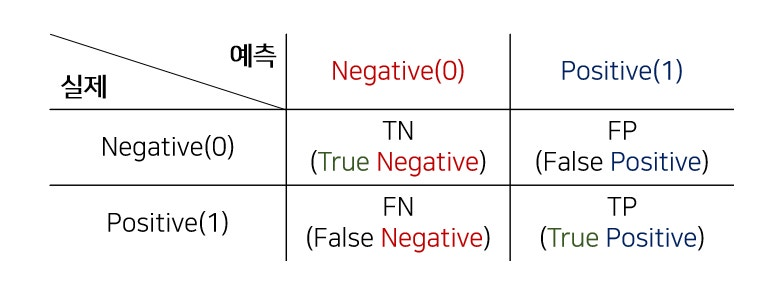

####**3.3.3 정밀도와 재현율**


In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

정밀도는 높지만 재현율은 높지 않다는 것을 확인  
정밀도와 재현율을 **F1 점수 (정밀도와 재현율의 조화 평균)** 라고 하는 하나의 숫자로 만들면 편함  
조화평균은 낮은 값에 훨씬 더 높은 비중을 둠, 그렇기에 F1 점수가 높으려면 두 개 다 높아야함  
$$
\text{F1} = 2 \cdot \frac{\text{정밀도} \cdot \text{재현율}}{\text{정밀도} + \text{재현율}}
$$
$$
\text{F1} = \frac{2TP}{2TP + FP + FN}
$$
  
    
F1 점수를 위해서는 f1_score() 함수 사용

In [21]:
#f1_score() 함수
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음  
상황에 따라 둘의 중요도 차이가 있음  
걸러내야하는 것이 더 중요한 경우 높은 정밀도를 필요로 함  
  
하지만 정밀도와 재현율을 모두 올리는 것은 불가능  
**정밀도/재현율 트레이드오프**

####**3.3.4 정밀도/재현율 트레이드오프**
SGDClassifier는 결정 함수를 사용해 각 샘플의 점수를 계산   
점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당   
가장 낮은 점수부터 가장 높은 점수까지 몇 개의 숫자를 나열했을 때 결정 임곗값이 어디냐에 따라 정밀도와 재현율이 결정.  
음성 예측에 가까워질수록 재현율이 오르고 양성 예측에 가까워질수록 정밀도가 오름  
  
사이킷런에서 임곗값 수동 지정은 불가능하지만 예측에 사용한 점수는 확인 가능   
분류기의 predict() 대신 decision_function() 을 사용하면 각 샘플의 점수를 얻을 수 있음.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold=0 # 임곗값
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([ True])

여기서 SGDClassifier의 임곗값이 0이므로 predict()와 같은 결과를 반환  


In [24]:
# 임곗값 높여서
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값을 높이면 재현율이 줄어드는 것은 확인  
  
적절한 임곗값 설정을 위해 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구함. 이 과정에서는 예측결과가 아닌 결정점수를 반환하도록 지정

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precision_recall_curve() 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산  
 (precision_recall_curve() 함수는 무한한 임곗값에 해당하는 값으로 마지막에 정밀도+1, 재현율 +0을 함)

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(close=None, block=None)>

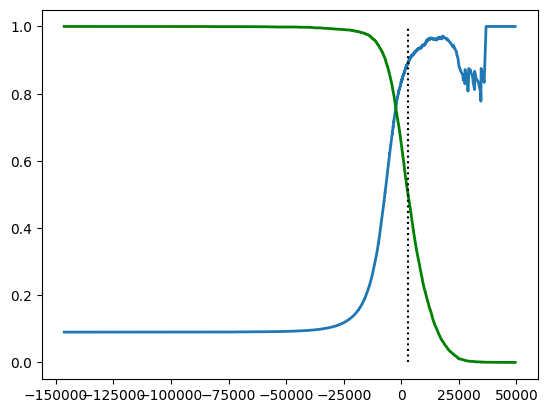

In [27]:
# 임곗값 3000일 때의 그래프 그리기
plt.plot(thresholds, precisions[:-1], label="정밀도", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임곗값")
plt.show